# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Functions for my simulations
from dyn_cond_fig_functions import *


# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

# Figure 6a

/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)
/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)
/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


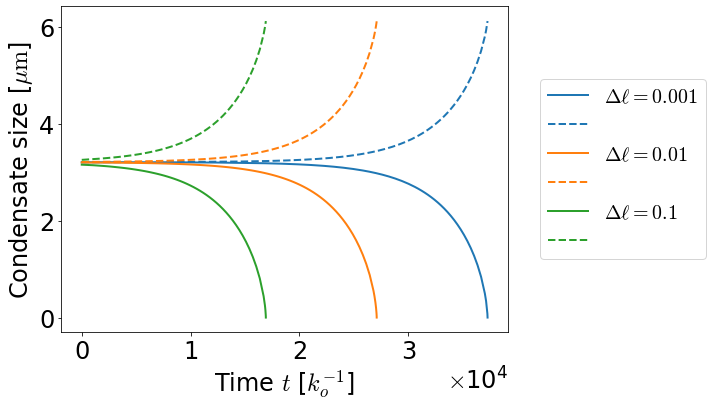

In [3]:
# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=7

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))


sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + 0.0005, max_ld - 0.0005],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
_ = axarr.plot(sol.t, sol.y[1], color="C0", label="$\Delta \ell = 0.001$", linestyle="-")
_ = axarr.plot(sol.t, sol.y[0], color="C0",  linestyle="--")

sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + 0.005, max_ld - 0.005],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
_ = axarr.plot(sol.t, sol.y[1], color="C1", label="$\Delta \ell = 0.01$", linestyle="-")
_ = axarr.plot(sol.t, sol.y[0], color="C1",  linestyle="--")

sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + 0.05, max_ld - 0.05],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
_ = axarr.plot(sol.t, sol.y[1], color="C2", label="$\Delta \ell = 0.1$", linestyle="-")
_ = axarr.plot(sol.t, sol.y[0], color="C2",  linestyle="--")
# print(sol.t[-1])

_ = axarr.legend(
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    labels=[
        "$\Delta \ell = 0.001$",
        None,
        "$\Delta \ell = 0.01$",
        None,
        "$\Delta \ell = 0.1$",
        None,
    ],
)
_ = axarr.set_xlabel("Time $t$ [$k_o^{-1}$]")
_ = axarr.set_ylabel(r"Condensate size [$\mu {\rm m}$]")
# plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
axarr.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.savefig("Figure6/size_vs_time.png",dpi=600, bbox_inches="tight")

7.320842585649917


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


1 16517.471248430844
6.6404510102647025


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


2 13334.517280432203
5.958524776032215


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


3 10437.225705267041
5.274635431150722


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


4 7837.632881630145
4.588142181763206


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


5 5537.575960458592
3.8980246586677327


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


6 3558.8855047191696
3.2025117520848743


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


7 1933.578352684222
2.498111677028162


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


8 714.1104693225303


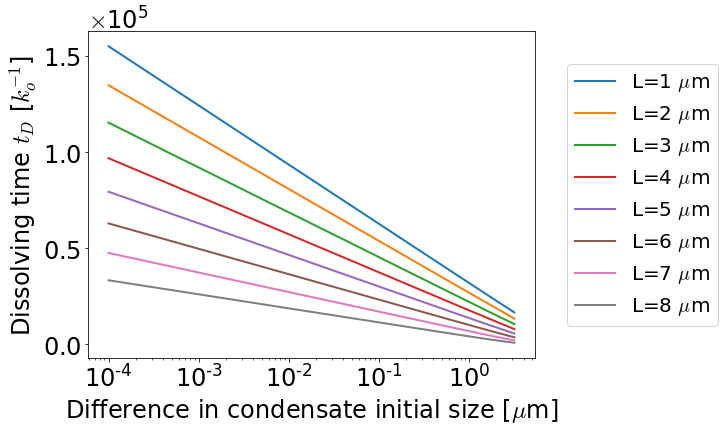

In [4]:

# diff_arr = np.linspace(0.0001, 2, 10)
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
diff_arr = np.logspace(-4, .5, 20)

for L in range(1, 9, 1):
    max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)
    print(max_ld)
    life_time = []
    for diff in diff_arr:
        sol = solve_ivp(
            two_cond_size_continuous_deriv,
            [0, tmax],
            [max_ld - 0.5 * diff, max_ld + 0.5 * diff],
            args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
            dense_output=True,
        )
        life_time.append(sol.t[-1])
    print(L, life_time[-1])
    _ = axarr.semilogx(diff_arr, life_time, label=f"L={L} $\mu$m")

_ = axarr.set_xlabel("Difference in condensate initial size [$\mu$m]")
_ = axarr.set_ylabel("Dissolving time $t_{D}$ [$k_o^{-1}$]")
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
# plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
axarr.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fig.savefig("Figure6/dissolve_vs_initial_diff.png",dpi=600, bbox_inches="tight")



/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)
/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)
/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)
/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld),

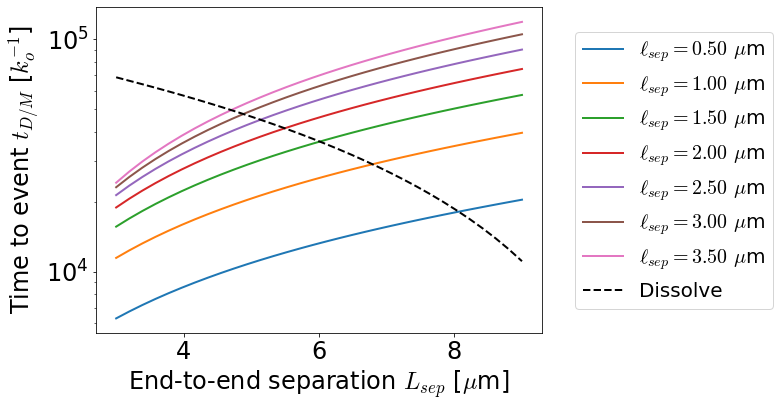

In [5]:
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
l_sep_arr = np.linspace(3., 9., 32)

x_sep_arr = np.linspace(0.5, 3.5, 7)
y_com =0.5 * Lc


graph_dissolve_flag = True
for x_sep in x_sep_arr:
    t_merge_arr = np.zeros_like(l_sep_arr)
    t_dissolve_arr = np.zeros_like(l_sep_arr)
    # Get next color in tablue color cycle
    color = next(axarr._get_lines.prop_cycler)["color"]
    for i, lsep in enumerate(l_sep_arr):
        # Merge times
        t_merge_arr[i] = tmerge_exact(x_sep, y_com, lsep, Lc, nu, gamma, alpha, kappa, b, beta)
        
        if graph_dissolve_flag:
            # Dissolve time
            max_ld = calc_max_length_in_two_condensates(lsep, Lc, nu, alpha, gamma, kappa)
            sol = solve_ivp(
                two_cond_size_continuous_deriv,
                [0, tmax],
                [max_ld - b*.5, max_ld + b*.5],
                args=(nu, gamma, alpha, kappa, lsep, Lc, b, beta),
                dense_output=True,
            )

            t_dissolve_arr[i] = sol.t[-1]
    graph_dissovle_flag = False

    _ = axarr.semilogy(l_sep_arr, t_merge_arr, color=color, label=f"$\ell_{{sep}}={x_sep:.2f}$ $\mu$m")

_ = axarr.semilogy(l_sep_arr, t_dissolve_arr, color='k', linestyle='--', label="Dissolve")
        
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))


_ = axarr.set_xlabel("End-to-end separation $L_{sep}$ [$\mu$m]")
_ = axarr.set_ylabel("Time to event $t_{D/M}$ [$k_o^{-1}$]")

fig.savefig('Figure6/dissolve_merge_compare.png', dpi=600, bbox_inches='tight')


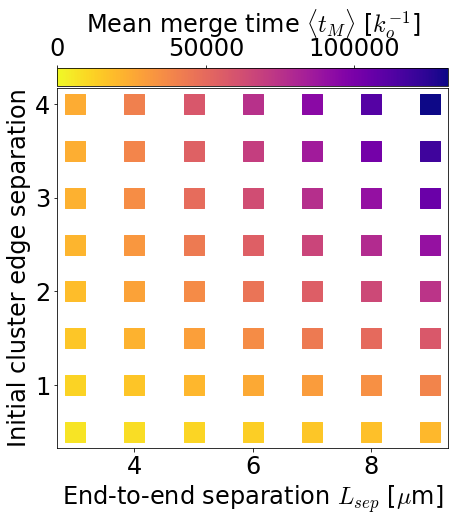

In [30]:
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))
plot_params = {'s':400, 'marker':'s'}

l_sep_arr = np.linspace(3., 9., 7)
x_sep_arr = np.linspace(0.5, 4.0, 8)
y_com =0.5 * Lc

X_arr = []
Y_arr = []
tmerge_arr = []

for x_sep in x_sep_arr:
    for i, lsep in enumerate(l_sep_arr):
        # Merge times
        X_arr += [lsep]
        Y_arr += [x_sep]
        tmerge_arr += [tmerge_exact(x_sep, y_com, lsep, Lc, nu, gamma, alpha, kappa, b, beta)]
        
        # if graph_dissolve_flag:
        #     # Dissolve time
        #     max_ld = calc_max_length_in_two_condensates(lsep, Lc, nu, alpha, gamma, kappa)
        #     sol = solve_ivp(
        #         two_cond_size_continuous_deriv,
        #         [0, tmax],
        #         [max_ld - b*.5, max_ld + b*.5],
        #         args=(nu, gamma, alpha, kappa, lsep, Lc, b, beta),
        #         dense_output=True,
        #     )

#     _ = axarr.semilogy(l_sep_arr, t_merge_arr, color=color, label=f"$\ell_{{sep}}={x_sep:.2f}$ $\mu$m")

# _ = axarr.semilogy(l_sep_arr, t_dissolve_arr, color='k', linestyle='--', label="Dissolve")
        
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

max_color_bar = np.max(tmerge_arr)
_ = axarr.scatter(X_arr, Y_arr, c=mpl.cm.plasma_r(tmerge_arr/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr).append_axes("top", size="5%", pad=0.03)
cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.2, label=rf'Mean merge time $\langle t_M \rangle$ [$k_o^{{-1}}$]', )
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

_ = axarr.set_ylabel('Initial cluster edge separation')
_ = axarr.set_xlabel("End-to-end separation $L_{sep}$ [$\mu$m]")

# fig.savefig('Figure6/dissolve_merge_compare.png', dpi=600, bbox_inches='tight')


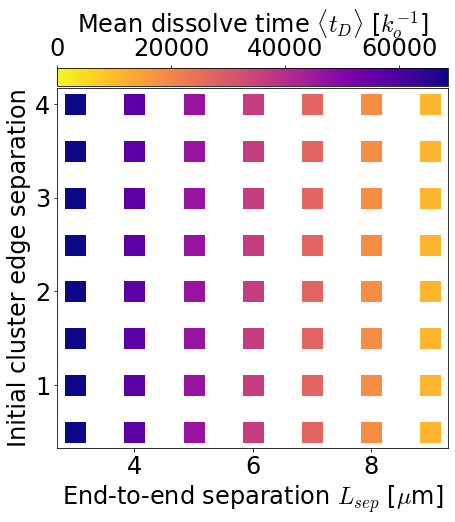

In [14]:
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))
plot_params = {'s':400, 'marker':'s'}

l_sep_arr = np.linspace(3., 9., 7)
x_sep_arr = np.linspace(0.5, 4.0, 8)
y_com =0.5 * Lc

X_arr = []
Y_arr = []
t_event_arr = []

for x_sep in x_sep_arr:
    for i, lsep in enumerate(l_sep_arr):
        # Merge times
        X_arr += [lsep]
        Y_arr += [x_sep]
        t_merge = tmerge_exact(x_sep, y_com, lsep, Lc, nu, gamma, alpha, kappa, b, beta)
        
        # Dissolve time
        max_ld = calc_max_length_in_two_condensates(lsep, Lc, nu, alpha, gamma, kappa)
        sol = solve_ivp(
            two_cond_size_continuous_deriv,
            [0, tmax],
            [max_ld - b*.5, max_ld + b*.5],
            args=(nu, gamma, alpha, kappa, lsep, Lc, b, beta),
            dense_output=True,
        )

        t_dissolve = sol.t[-1]

        t_event_arr += [t_dissolve]

#     _ = axarr.semilogy(l_sep_arr, t_merge_arr, color=color, label=f"$\ell_{{sep}}={x_sep:.2f}$ $\mu$m")

# _ = axarr.semilogy(l_sep_arr, t_dissolve_arr, color='k', linestyle='--', label="Dissolve")
        
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

max_color_bar = np.max(t_event_arr)
_ = axarr.scatter(X_arr, Y_arr, c=mpl.cm.plasma_r(t_event_arr/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr).append_axes("top", size="5%", pad=0.03)
cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.2, label=rf'Mean dissolve time $\langle t_{{D}} \rangle$ [$k_o^{{-1}}$]')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

_ = axarr.set_ylabel('Initial cluster edge separation')
_ = axarr.set_xlabel("End-to-end separation $L_{sep}$ [$\mu$m]")

# fig.savefig('Figure6/dissolve_merge_compare.png', dpi=600, bbox_inches='tight')


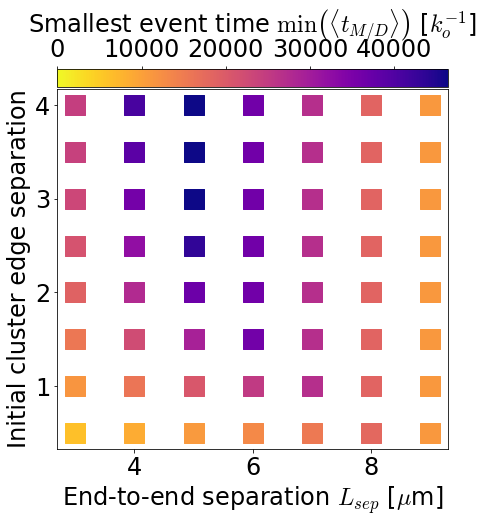

In [33]:
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))
plot_params = {'s':400, 'marker':'s'}

l_sep_arr = np.linspace(3., 9., 7)
x_sep_arr = np.linspace(0.5, 4.0, 8)
y_com =0.5 * Lc

X_arr = []
Y_arr = []
t_event_arr = []

for x_sep in x_sep_arr:
    for i, lsep in enumerate(l_sep_arr):
        # Merge times
        X_arr += [lsep]
        Y_arr += [x_sep]
        t_merge = tmerge_exact(x_sep, y_com, lsep, Lc, nu, gamma, alpha, kappa, b, beta)
        
        # Dissolve time
        max_ld = calc_max_length_in_two_condensates(lsep, Lc, nu, alpha, gamma, kappa)
        sol = solve_ivp(
            two_cond_size_continuous_deriv,
            [0, tmax],
            [max_ld - b*.5, max_ld + b*.5],
            args=(nu, gamma, alpha, kappa, lsep, Lc, b, beta),
            dense_output=True,
        )

        t_dissolve = sol.t[-1]

        t_event_arr += [min(t_dissolve, t_merge)]

#     _ = axarr.semilogy(l_sep_arr, t_merge_arr, color=color, label=f"$\ell_{{sep}}={x_sep:.2f}$ $\mu$m")

# _ = axarr.semilogy(l_sep_arr, t_dissolve_arr, color='k', linestyle='--', label="Dissolve")
        
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

max_color_bar = np.max(t_event_arr)
_ = axarr.scatter(X_arr, Y_arr, c=mpl.cm.plasma_r(t_event_arr/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr).append_axes("top", size="5%", pad=0.03)
cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.2, label=rf'Smallest event time $\min \left(\langle t_{{M/D}} \rangle\right)$ [$k_o^{{-1}}$]')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

_ = axarr.set_ylabel('Initial cluster edge separation')
_ = axarr.set_xlabel("End-to-end separation $L_{sep}$ [$\mu$m]")

# fig.savefig('Figure6/dissolve_merge_compare.png', dpi=600, bbox_inches='tight')


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:285: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


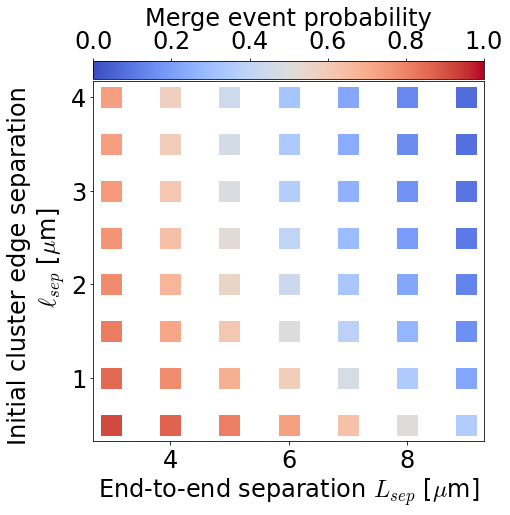

In [28]:
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))
plot_params = {'s':400, 'marker':'s'}

l_sep_arr = np.linspace(3., 9., 7)
x_sep_arr = np.linspace(0.5, 4.0, 8)
y_com =0.5 * Lc

X_arr = []
Y_arr = []
t_event_arr = []

for x_sep in x_sep_arr:
    for i, lsep in enumerate(l_sep_arr):
        # Merge times
        X_arr += [lsep]
        Y_arr += [x_sep]
        t_merge = tmerge_exact(x_sep, y_com, lsep, Lc, nu, gamma, alpha, kappa, b, beta)
        
        # Dissolve time
        max_ld = calc_max_length_in_two_condensates(lsep, Lc, nu, alpha, gamma, kappa)
        sol = solve_ivp(
            two_cond_size_continuous_deriv,
            [0, tmax],
            [max_ld - b*.5, max_ld + b*.5],
            args=(nu, gamma, alpha, kappa, lsep, Lc, b, beta),
            dense_output=True,
        )

        t_dissolve = sol.t[-1]

        # t_event_arr += [t_dissolve/t_merge]
        t_event_arr += [(1./t_merge)/((1./t_merge)+(1./t_dissolve))]
#     _ = axarr.semilogy(l_sep_arr, t_merge_arr, color=color, label=f"$\ell_{{sep}}={x_sep:.2f}$ $\mu$m")

# _ = axarr.semilogy(l_sep_arr, t_dissolve_arr, color='k', linestyle='--', label="Dissolve")
        
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
t_event_arr = np.array(t_event_arr)

# max_color_bar = np.max(t_event_arr)
max_color_bar = 1.
_ = axarr.scatter(X_arr, Y_arr, c=mpl.cm.coolwarm(t_event_arr/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr).append_axes("top", size="5%", pad=0.03)
cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='coolwarm'), cax = cax1, orientation='horizontal', pad=0.2, 
                #    label=rf'Event time ratio $\log\left(\langle t_{{D}} \rangle/\langle t_{{M}} \rangle \right)$ ')
                   label=rf'Merge event probability')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

_ = axarr.set_ylabel('Initial cluster edge separation \n $\ell_{sep}$ [$\mu$m]')
_ = axarr.set_xlabel("End-to-end separation $L_{sep}$ [$\mu$m]")

# fig.savefig('Figure6/dissolve_merge_compare.png', dpi=600, bbox_inches='tight')


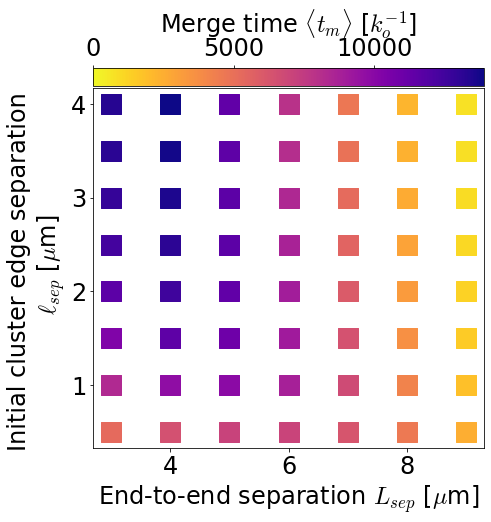

In [7]:
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))
plot_params = {'s':400, 'marker':'s'}

l_sep_arr = np.linspace(3., 9., 7)
x_sep_arr = np.linspace(0.5, 4.0, 8)
y_com =0.5 * Lc

X_arr = []
Y_arr = []
t_event_arr = []

for x_sep in x_sep_arr:
    for i, lsep in enumerate(l_sep_arr):
        # Merge times
        X_arr += [lsep]
        Y_arr += [x_sep]
        t_merge = tmerge_exact(x_sep, y_com, lsep, Lc, nu, gamma, alpha, kappa, b, beta)
        
        # Dissolve time
        max_ld = calc_max_length_in_two_condensates(lsep, Lc, nu, alpha, gamma, kappa)
        sol = solve_ivp(
            two_cond_size_continuous_deriv,
            [0, tmax],
            [max_ld - b*.5, max_ld + b*.5],
            args=(nu, gamma, alpha, kappa, lsep, Lc, b, beta),
            dense_output=True,
        )

        t_dissolve = sol.t[-1]

        # t_event_arr += [t_dissolve/t_merge]
        t_event_arr += [(1./t_merge)/(((1./t_merge)+(1./t_dissolve))**2)]
#     _ = axarr.semilogy(l_sep_arr, t_merge_arr, color=color, label=f"$\ell_{{sep}}={x_sep:.2f}$ $\mu$m")

# _ = axarr.semilogy(l_sep_arr, t_dissolve_arr, color='k', linestyle='--', label="Dissolve")
        
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
t_event_arr = np.array(t_event_arr)

max_color_bar = np.max(t_event_arr)
# max_color_bar = 1.
_ = axarr.scatter(X_arr, Y_arr, c=mpl.cm.plasma_r(t_event_arr/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr).append_axes("top", size="5%", pad=0.03)
cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.2, 
                #    label=rf'Event time ratio $\log\left(\langle t_{{D}} \rangle/\langle t_{{M}} \rangle \right)$ ')
                   label=rf'Merge time $\langle t_m \rangle$ [$k_o^{{-1}}$]')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

_ = axarr.set_ylabel('Initial cluster edge separation \n $\ell_{sep}$ [$\mu$m]')
_ = axarr.set_xlabel("End-to-end separation $L_{sep}$ [$\mu$m]")

# fig.savefig('Figure6/dissolve_merge_compare.png', dpi=600, bbox_inches='tight')


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


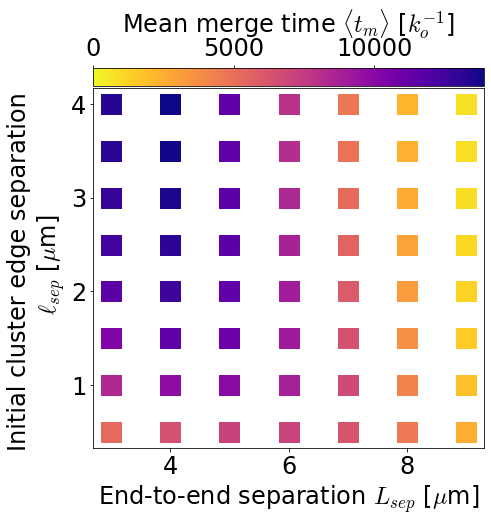

In [19]:
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))
plot_params = {'s':400, 'marker':'s'}

l_sep_arr = np.linspace(3., 9., 7)
x_sep_arr = np.linspace(0.5, 4.0, 8)
y_com =0.5 * Lc

X_arr = []
Y_arr = []
t_event_arr = []

for x_sep in x_sep_arr:
    for i, lsep in enumerate(l_sep_arr):
        # Merge times
        X_arr += [lsep]
        Y_arr += [x_sep]
        t_merge = tmerge_exact(x_sep, y_com, lsep, Lc, nu, gamma, alpha, kappa, b, beta)
        
        # Dissolve time
        max_ld = calc_max_length_in_two_condensates(lsep, Lc, nu, alpha, gamma, kappa)
        sol = solve_ivp(
            two_cond_size_continuous_deriv,
            [0, tmax],
            [max_ld - b*.5, max_ld + b*.5],
            args=(nu, gamma, alpha, kappa, lsep, Lc, b, beta),
            dense_output=True,
        )

        t_dissolve = sol.t[-1]

        # t_event_arr += [t_dissolve/t_merge]
        t_event_arr += [(1./t_merge)/(((1./t_merge)+(1./t_dissolve))**2)]
#     _ = axarr.semilogy(l_sep_arr, t_merge_arr, color=color, label=f"$\ell_{{sep}}={x_sep:.2f}$ $\mu$m")

# _ = axarr.semilogy(l_sep_arr, t_dissolve_arr, color='k', linestyle='--', label="Dissolve")
        
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
t_event_arr = np.array(t_event_arr)

max_color_bar = np.max(t_event_arr)
# max_color_bar = 20000.
_ = axarr.scatter(X_arr, Y_arr, c=mpl.cm.plasma_r(t_event_arr/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr).append_axes("top", size="5%", pad=0.03)
cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.2, 
                #    label=rf'Event time ratio $\log\left(\langle t_{{D}} \rangle/\langle t_{{M}} \rangle \right)$ ')
                   label=rf'Mean merge time $\langle t_m \rangle$ [$k_o^{{-1}}$]')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

_ = axarr.set_ylabel('Initial cluster edge separation \n $\ell_{sep}$ [$\mu$m]')
_ = axarr.set_xlabel("End-to-end separation $L_{sep}$ [$\mu$m]")

# fig.savefig('Figure6/dissolve_merge_compare.png', dpi=600, bbox_inches='tight')


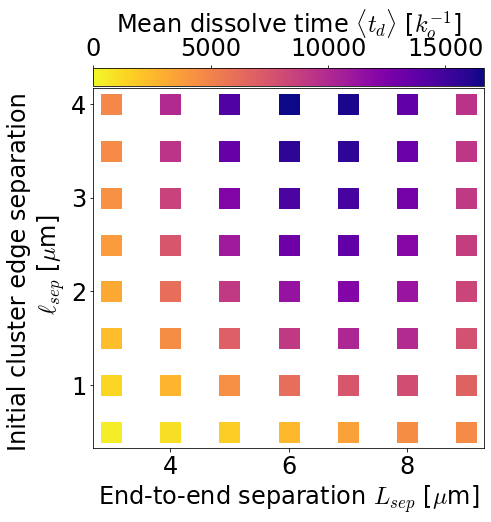

In [18]:
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))
plot_params = {'s':400, 'marker':'s'}

l_sep_arr = np.linspace(3., 9., 7)
x_sep_arr = np.linspace(0.5, 4.0, 8)
y_com =0.5 * Lc

X_arr = []
Y_arr = []
t_event_arr = []

for x_sep in x_sep_arr:
    for i, lsep in enumerate(l_sep_arr):
        # Merge times
        X_arr += [lsep]
        Y_arr += [x_sep]
        t_merge = tmerge_exact(x_sep, y_com, lsep, Lc, nu, gamma, alpha, kappa, b, beta)
        
        # Dissolve time
        max_ld = calc_max_length_in_two_condensates(lsep, Lc, nu, alpha, gamma, kappa)
        sol = solve_ivp(
            two_cond_size_continuous_deriv,
            [0, tmax],
            [max_ld - b*.5, max_ld + b*.5],
            args=(nu, gamma, alpha, kappa, lsep, Lc, b, beta),
            dense_output=True,
        )

        t_dissolve = sol.t[-1]

        # t_event_arr += [t_dissolve/t_merge]
        t_event_arr += [(1./t_dissolve)/(((1./t_merge)+(1./t_dissolve))**2)]
#     _ = axarr.semilogy(l_sep_arr, t_merge_arr, color=color, label=f"$\ell_{{sep}}={x_sep:.2f}$ $\mu$m")

# _ = axarr.semilogy(l_sep_arr, t_dissolve_arr, color='k', linestyle='--', label="Dissolve")
        
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
t_event_arr = np.array(t_event_arr)

max_color_bar = np.max(t_event_arr)
# max_color_bar = 40000
_ = axarr.scatter(X_arr, Y_arr, c=mpl.cm.plasma_r(t_event_arr/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr).append_axes("top", size="5%", pad=0.03)
cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.2, 
                #    label=rf'Event time ratio $\log\left(\langle t_{{D}} \rangle/\langle t_{{M}} \rangle \right)$ ')
                   label=rf'Mean dissolve time $\langle t_d \rangle$ [$k_o^{{-1}}$]')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

_ = axarr.set_ylabel('Initial cluster edge separation \n $\ell_{sep}$ [$\mu$m]')
_ = axarr.set_xlabel("End-to-end separation $L_{sep}$ [$\mu$m]")

# fig.savefig('Figure6/dissolve_merge_compare.png', dpi=600, bbox_inches='tight')


# Supplement

[ 1966.08408121  4414.10143197  6822.87235271  9192.75529152
 11524.10829716 13817.28887665 16072.65385359 18290.55922732
 20471.36003292 22615.41020249 24723.06242763 26794.66802341
 28830.57679385 30831.13689925 32796.69472525 34727.59475398
 36624.17943728 38486.78907212 40315.76167842 42111.43287927]


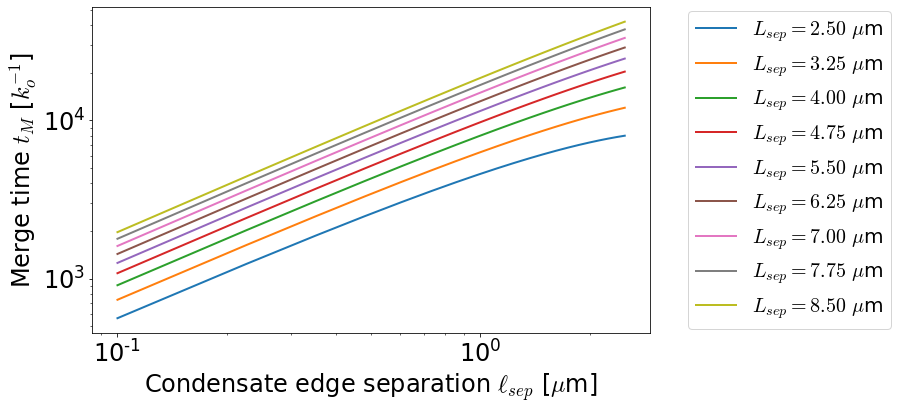

In [8]:
fig, axarr = plt.subplots(1, 1, figsize=(10, 6))
lsep_arr = np.linspace(2.5, 8.5, 9)

x_sep_arr = np.linspace(0.1, 2.5, 20)
y_com = 0.5 * Lc

t_merge_arr = np.zeros_like(x_sep_arr)

for l_sep in lsep_arr:
    for i, x_sep in enumerate(x_sep_arr):
        t_merge_arr[i] = tmerge_exact(x_sep, y_com, l_sep, Lc, nu, gamma, alpha, kappa, b, beta)

    _ = axarr.loglog(x_sep_arr, t_merge_arr, label=f"$L_{{sep}}={l_sep:.2f}$ $\mu$m")

print(t_merge_arr)
_ = axarr.set_xlabel("Condensate edge separation $\ell_{sep}$ [$\mu$m]")
_ = axarr.set_ylabel("Merge time $t_{M}$ [$k_o^{-1}$]")
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))


# Approximation

/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:285: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


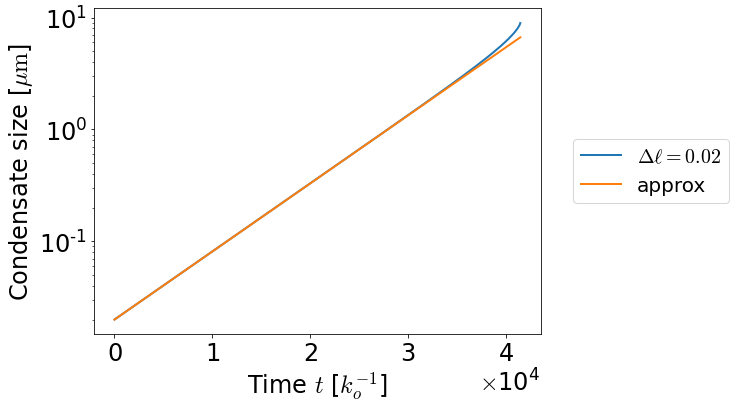

In [41]:
# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

def dl_approx(t, L, Lc, b, alpha, gamma, nu, kappa, beta):
    l_bar = 2 * calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)
    xi = 4.* np.pi * gamma *np.power((3.*alpha)/(8*np.pi), 2./3.)
    exp_fact = (16.* b*b* beta*xi/(9.*np.power(l_bar, 4./3.)))
    return 2.*b*np.exp(exp_fact*t)

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))


sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + b, max_ld - b],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
_ = axarr.plot(sol.t, sol.y[0] - sol.y[1], color="C0", label="$\Delta \ell = 0.02$", linestyle="-")
_ = axarr.plot(sol.t, dl_approx(sol.t, L, Lc, b, alpha, gamma, nu, kappa, beta), color="C1", label="approx")
_ = axarr.set_yscale('log')


_ = axarr.legend(
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
)
_ = axarr.set_xlabel("Time $t$ [$k_o^{-1}$]")
_ = axarr.set_ylabel(r"Condensate size [$\mu {\rm m}$]")
# plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
axarr.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.savefig("Figure6/size_vs_time.png",dpi=600, bbox_inches="tight")